## Import Libraries

Mix of libraries for data preprocessing, visualization, and modeling.

In [1]:
import random
random.seed(42)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
# import time

from PIL import Image
import imagesize

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics, svm

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

from scipy.ndimage import sobel

2024-06-11 16:48:00.576909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exploration

Here, we will be creating a dataframe with all our image paths (as strings), bloodcell type, and image dimension information. We will take a look at if our data is balanced or not with the bloodcell type counts and the image dimension counts.

In [2]:
# Dataset folder has 8 different folders, which represent 8 different bloodcells we will be classifying
# Open up folder names and remove folder names that are not bloodcell types

# Original kaggle dataset has images stored in each of the 8 folders, so we made a folder that contained all the images
# so that it is easier to convert the images to numpy arrays later on

bloodcells = os.listdir("bloodcells_dataset")
bloodcells = [x for x in bloodcells if x not in ['.DS_Store', 'All_Images']]

bloodcells

['basophil',
 'neutrophil',
 'ig',
 'monocyte',
 'eosinophil',
 'erythroblast',
 'lymphocyte',
 'platelet']

In [3]:
def image_df(folder_names):

    '''
    Outputs a dataframe for image paths (as strings), bloodcell type, and image dimension information.

    Args:
        1) folder_names (list): list of bloodcell type folders

    Returns:
        Dataframe with all image paths, bloodcell types, and image dimensions
    '''

    # initialize empty list to store dataframes that contain image strings and bloodcell type
    dfs = []

    # loop through bloodcell types and store image paths and bloodcell categories
    for i in range(len(folder_names)):

        # jpg string paths
        images = os.listdir('bloodcells_dataset/' + folder_names[i]) 

        # dataframe holding specific bloodcell type info (string path and type name)
        df = pd.DataFrame(data = {'images': images, 'type': folder_names[i]})

        # append dataframe to list
        dfs.append(df)

    # combine all dataframes
    all_data = pd.concat(dfs)

    # Remove image paths that may have been accidentally copied or contain .DS_Store
    all_data = all_data[all_data['images'].str.contains('.DS_Store') == False]
    all_data = all_data[all_data['images'].str.contains('copy') == False]

    # Convert bloodcell types to numbers for our model
    le = LabelEncoder()
    all_data['type_category'] = all_data['type'] # keep a copy of bloodcell types by name
    all_data['type'] = le.fit_transform(all_data['type'])

    # Store dimensions of image incase we find different dimensions 
    dimensions = pd.Series([imagesize.get('bloodcells_dataset/All_Images/' + x) for x in all_data['images']])
    widths, heights = map(list, zip(*dimensions))
    all_data['width'] = widths
    all_data['height'] = heights
    all_data['dimensions'] = all_data['width'].astype(str) + ' x ' + all_data['height'].astype(str)

    # Reset index 
    all_data = all_data.reset_index(drop = True)
    
    return all_data


    

In [4]:
df = image_df(bloodcells)

df

,images,type,type_category,width,height,dimensions
0,BA_689200.jpg,0,basophil,360,363,360 x 363
1,BA_883452.jpg,0,basophil,360,363,360 x 363
2,BA_382161.jpg,0,basophil,366,369,366 x 369
3,BA_175579.jpg,0,basophil,360,363,360 x 363
4,BA_775722.jpg,0,basophil,360,363,360 x 363
...,...,...,...,...,...,...
17087,PLATELET_495918.jpg,7,platelet,360,363,360 x 363
17088,PLATELET_897238.jpg,7,platelet,360,363,360 x 363
17089,PLATELET_750430.jpg,7,platelet,360,363,360 x 363
17090,PLATELET_810431.jpg,7,platelet,360,363,360 x 363


Let's take a look at one image from each of our bloodcell types to see what these cells look like.

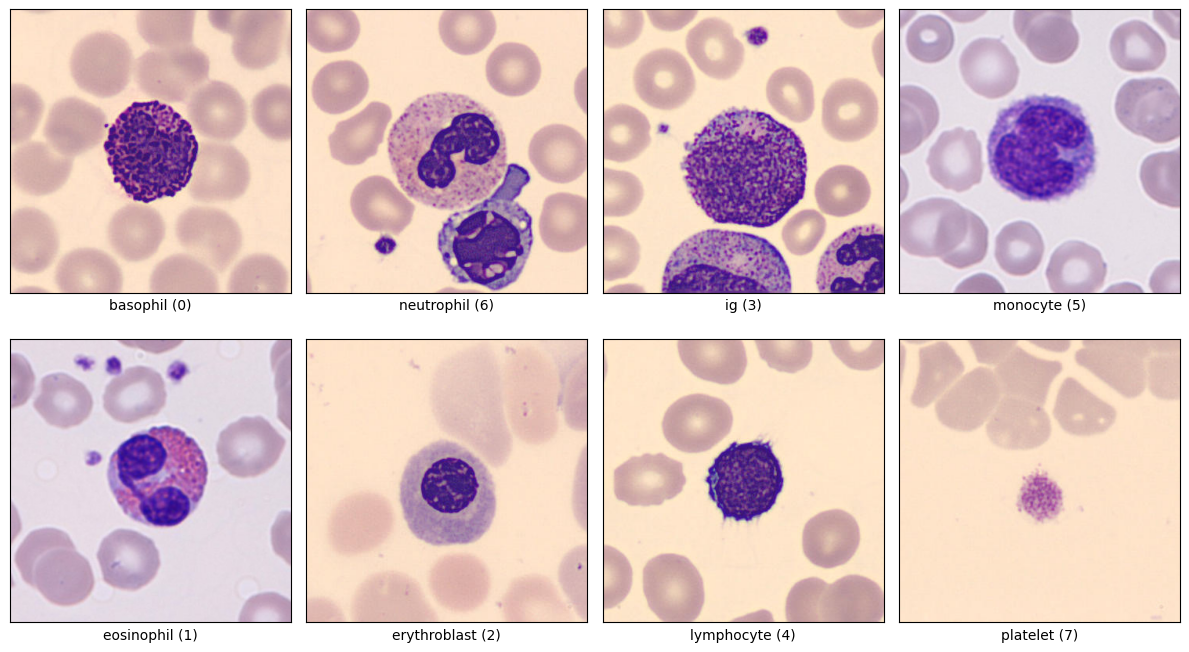

In [5]:
sample_pics = [df[df['type_category'] == x][['images', 'type_category', 'type']].sample(1).values.reshape(3) for x in bloodcells]

fig, ax = plt.subplots(2, 4, figsize = (12, 12))

for i in range(len(sample_pics)):
    
    img = mpimg.imread('bloodcells_dataset/All_Images/' + sample_pics[i][0])

    if i < 4:
        ax[0, i].imshow(img)
        ax[0, i].set_xlabel(sample_pics[i][1] + f' ({sample_pics[i][2]})')
        ax[0, i].set_xticklabels([])
        ax[0, i].set_yticklabels([])
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
    else:
        ax[1, i - 4].imshow(img)
        ax[1, i - 4].set_xlabel(sample_pics[i][1] + f' ({sample_pics[i][2]})')
        ax[1, i - 4].set_xticklabels([])
        ax[1, i - 4].set_yticklabels([])
        ax[1, i - 4].set_xticks([])
        ax[1, i - 4].set_yticks([])


plt.tight_layout()
plt.subplots_adjust(top = 0.75, bottom = 0.1)

Let's take a look at the distribution of images by dimension (width x height) and by bloodcell type.

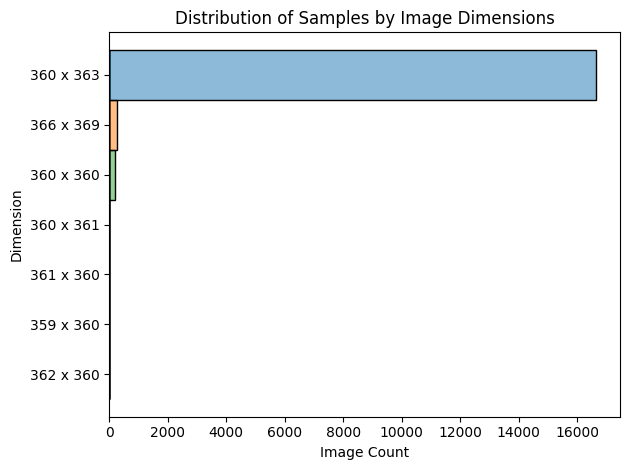

In [6]:
ax = sns.histplot(data = df, y = 'dimensions', hue = 'dimensions')

ax.get_legend().set_visible(False)

plt.xlabel("Image Count")

plt.ylabel("Dimension")

plt.title("Distribution of Samples by Image Dimensions")

plt.tight_layout()

plt.show()

It seems like most images are 360 x 363 pixels, and we will end up resizing the images to 32 pixels later on so the imbalance does not really matter here.

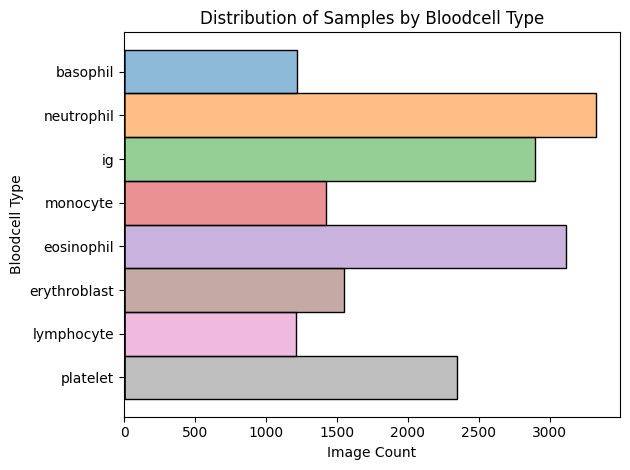

In [7]:
ax = sns.histplot(data = df, y = 'type_category', hue = 'type_category')

ax.get_legend().set_visible(False)

plt.xlabel("Image Count")

plt.ylabel("Bloodcell Type")

plt.title("Distribution of Samples by Bloodcell Type")

plt.tight_layout()

plt.show()

Looking at the number of images we have for each bloodcell type, it is clear we have an imbalanced image count for each type, which we will account for when splitting our data for training and testing.

## Sampling

Now we will create classes to sample our data for train, validation, and test sets and for converting images to arrays that can be used for our models. Because of our imbalanced representation of images for each bloodcell type, we will downsample the image count by type (sample 1000 images for a bloodcell type if the total amount of images for that type is < 2000 images and sample 1500 images if the total amount of images for that type is $\ge$ 2000 images) and in relation to the proportion of each bloodcell type compared to the overall number of images. We will then see if either sampling method results in a better performance when training our models.

In [8]:
class Sampling:
    '''
    Samples a bloodcell dataframe either by down-sampling or proportionally selecting the image count by bloodcell type

    Methods:
        1) __init__: initialize the data and sampling method
        2) sample_data: performs the sampling on the initialized data and given sampling method
        
    '''

    def __init__(self, data, sampling_method):

        self.data = data # bloodcell dataframe to sample
        
        self.sampling_method = sampling_method # downsample or porportional

    def sample_data(self, sampling_percent = 0.8):

        '''
        Samples the initialized data for the given sampling method

        Args:
            1) sampling_percent (float): Percent of data to use for training (only applicable for proportional sampling)

        Returns:
            Dataframe of sampled images and label
        '''

        # copy of data
        df = self.data.copy()

        # Find count of images by bloodcell type
        category_counts = df[['type']].value_counts().reset_index(name = 'count')

        # Will store training dataframes to concatenate later
        train_dfs = []

        # Down sampling
        if self.sampling_method == 'down':

            # Loop through each bloodcell type
            for i in range(len(category_counts)):

                # Select specific bloodcell type
                type = category_counts['type'][i]

                # If bloodcell type has more than 2000 images, sample 1500 images and if not, then sample 1000 images
                if category_counts['count'][i] >= 2000:
                    add_samples = df[df['type'] == type].sample(1500)
                else: 
                    add_samples = df[df['type'] == type].sample(1000)

                # Add sampled images to train_dfs list
                train_dfs.append(add_samples)

            # Combine all training dfs into one
            train = pd.concat(train_dfs)

            # Separate remaining data to make validation and test sets
            remaining_data = df[~df['images'].isin(train['images'])]

            # validation data consists of half of the remaining data
            validation = remaining_data.sample(int(len(remaining_data) / 2))

        # Proportional Sampling
        elif self.sampling_method == 'proportional': 

            # Number of training samples needed
            num_samples = int(sampling_percent * len(df))

            # Number of training and validation samples needed for each bloodcell type based on proportion
            # validation set is 20% of the training set size
            category_counts['prop'] = category_counts['count'] / len(df)
            category_counts['train_samples'] = (category_counts['prop'] * num_samples).astype('int32')
            category_counts['val_samples'] = (category_counts['train_samples'] * 0.25).astype('int32')
            category_counts['train_samples'] = category_counts['train_samples'] - category_counts['val_samples']

            # Store validation dataframes to concatenate later
            val_dfs = []

            # First sample data for training set 
            for i in range(len(category_counts)):

                # Select specific bloodcell type
                type = category_counts['type'][i]

                # Number of samples to take for specific bloodcell type
                samples = category_counts['train_samples'][i]

                # Separate training samples into its own dataframe
                add_samples = df[df['type'] == type].sample(samples)

                # Add sampled images to train_dfs list
                train_dfs.append(add_samples)

            # Combine all training dfs into one
            train = pd.concat(train_dfs)

             # Separate remaining data to make validation and test sets
            remaining_data = df[~df['images'].isin(train['images'])]

            # Sample remaining data for validation set
            for i in range(len(category_counts)):

                # Select specific bloodcell type
                type = category_counts['type'][i]

                # Number of samples to take for specific bloodcell type
                samples = category_counts['val_samples'][i]

                # Separate validation samples into its own dataframe
                add_samples = remaining_data[remaining_data['type'] == type].sample(samples)

                # Add sampled images to tval_dfs list
                val_dfs.append(add_samples)
            
            # Combine all validation dfs into one
            validation = pd.concat(val_dfs)

        # Inase there are NAs present in the train set, drop them
        # Convert all float columns to int columns (Bloodcell type marked as float during sampling process, eg. 1.0 instead of 1)
        train = train.dropna(how = 'all')
        float_cols = train.select_dtypes(np.number)
        train[float_cols.columns] = float_cols.astype('int32')

        # Test data is remanining data minus the validation data
        test = remaining_data[~remaining_data['images'].isin(validation['images'])]

        # Return train, val, test dataframes
        return train, validation, test
            

In [9]:
# Initialize sampling objects
down_sampling = Sampling(df, 'down')
proportional_sampling = Sampling(df, 'proportional')

# Create train, val, test dataframes for both sampling methods
down_train, down_val, down_test = down_sampling.sample_data()
prop_train, prop_val, prop_test = proportional_sampling.sample_data()

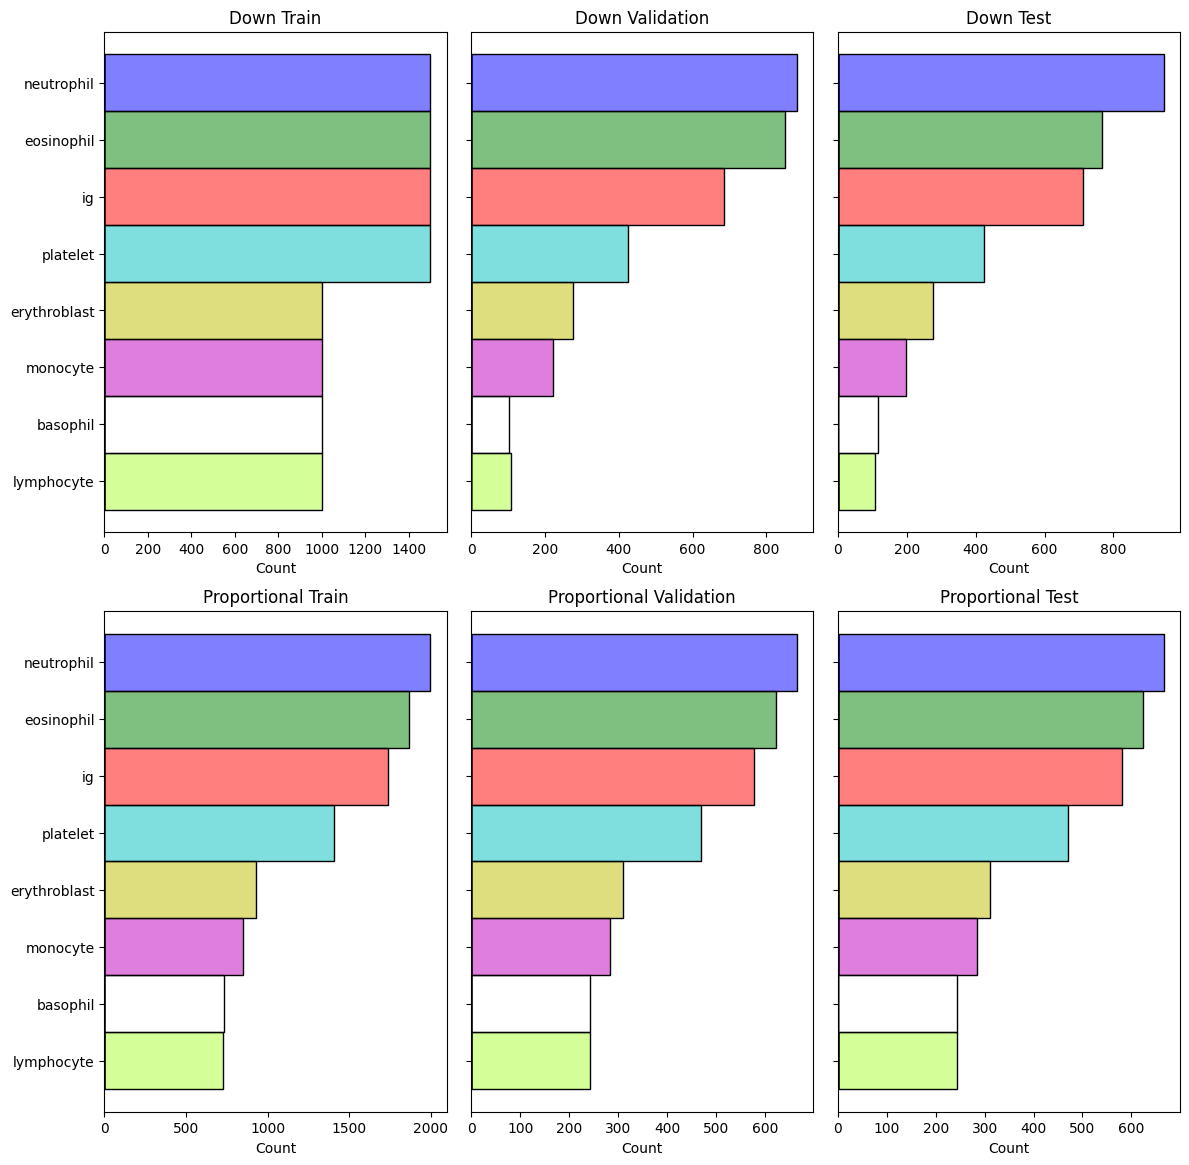

In [10]:
fig, ax = plt.subplots(2, 3, sharey = True, figsize = (12, 12))

palette={'neutrophil':'b', 'eosinophil':'g', 'ig':'r','platelet':'c', 'erythroblast':'y', 'monocyte':'k', 'monocyte': 'm', 'basophil': 'w', 'lymphocyte':'#AAFF32'}

sns.histplot(data = down_train, y = 'type_category', hue = 'type_category', ax = ax[0, 0], palette = palette)
ax[0, 0].get_legend().set_visible(False)
ax[0, 0].set(ylabel = '')
ax[0, 0].set_title('Down Train')
sns.histplot(data = down_val, y = 'type_category', hue = 'type_category', ax = ax[0, 1], palette = palette)
ax[0, 1].get_legend().set_visible(False)
ax[0, 1].set_title('Down Validation')
sns.histplot(data = down_test, y = 'type_category', hue = 'type_category', ax = ax[0, 2], palette = palette)
ax[0, 2].get_legend().set_visible(False)
ax[0, 2].set_title('Down Test')

sns.histplot(data = prop_train, y = 'type_category', hue = 'type_category', ax = ax[1, 0], palette = palette)
ax[1, 0].get_legend().set_visible(False)
ax[1, 0].set(ylabel = '')
ax[1, 0].set_title('Proportional Train')
sns.histplot(data = prop_val, y = 'type_category', hue = 'type_category', ax = ax[1, 1], palette = palette)
ax[1, 1].get_legend().set_visible(False)
ax[1, 1].set_title('Proportional Validation')
sns.histplot(data = prop_test, y = 'type_category', hue = 'type_category', ax = ax[1, 2], palette = palette)
ax[1, 2].get_legend().set_visible(False)
ax[1, 2].set_title('Proportional Test')

plt.tight_layout()
plt.subplots_adjust(top = 0.95, bottom = 0.05)

## Images to Arrays
Now that we have our sampling dataframes, we have to convert our images into arrays so that they can be used as input for our models. 

In [11]:
class Convert_Images:
    '''
    Converts image string paths to numpy arrays

    Methods:
        1) __init__: initialize the data, image path names, and bloodcell type labels
        2) load_image: convert an image to a tensorflow array
        3) image_arrays_and_labels: return all images from the data as 4d numpy arrays alongside their corresponding bloodcell type labels
    '''

    def __init__(self, data):

        self.data = data # bloodcell dataframe that contains images to convert

        self.file_names = (self.data)['images'].apply(lambda x: 'bloodcells_dataset/All_Images/' + x) # extract image string paths from data

        self.labels = self.data['type'] # extract bloodcell type labels from data

    def load_image(self, file_name, resize, edge):

        '''
        Convert an image into a tensor

        Args:
            1) file_name (string): image string path
            2) resize (int): resize pixels of image
            3) edge (bool): indicate if preprocessing needs to be done for edge detection

        Returns:
            tensor with image pixel values
        '''

        # read in image
        raw = tf.io.read_file(file_name)

        # turn image into tensor
        tensor = tf.io.decode_image(raw, expand_animations = False)

        # resize image tensor
        tensor = tf.image.resize(tensor, size = [resize, resize])

        # normalize pixel values, but not for edge detection (needs its own processing which will be done outside the class)
        if edge == True:
            tensor = tf.cast(tensor, tf.float32)
        else:    
            tensor = tf.cast(tensor, tf.float32) / 255.0
        
        return tensor

    def image_arrays_and_labels(self, resize = 32, edge = False):
        '''
        Convert dataframe of image paths into numpy arrays and bloodcell type labels

        Args:
            1) resize (int): resize pixels of image
            2) edge (bool): indicate if preprocessing needs to be done for edge detection

        Returns:
            4d numpy array of image pixel values and bloodcell type labels
        '''

        # Convert image file names into tensorflow dataset
        dataset = tf.data.Dataset.from_tensor_slices(self.file_names)
        
        # Apply function to each image that will convert it into a tensor    
        dataset = dataset.map(lambda file_name: self.load_image(file_name, resize, edge))

        # Convert tensors into numpy arrays
        images = np.array(list(dataset))
            
        return images, self.labels

In [12]:
# initialize image to array objects for train, val, and test dataframes from above
down_train_image_df, down_val_image_df, down_test_image_df = Convert_Images(down_train), Convert_Images(down_val), Convert_Images(down_test) 
prop_train_image_df, prop_val_image_df, prop_test_image_df = Convert_Images(prop_train), Convert_Images(prop_val), Convert_Images(prop_test)


# resize images to be 32 x 32 pixels
resize_pixels = 32

# apply image_arrays_and_labels method to objects resulting in arrays and labels
down_train_images, down_train_labels = down_train_image_df.image_arrays_and_labels(resize_pixels)
down_val_images, down_val_labels = down_val_image_df.image_arrays_and_labels(resize_pixels)
down_test_images, down_test_labels = down_test_image_df.image_arrays_and_labels(resize_pixels)
prop_train_images, prop_train_labels = prop_train_image_df.image_arrays_and_labels(resize_pixels)
prop_val_images, prop_val_labels = prop_val_image_df.image_arrays_and_labels(resize_pixels)
prop_test_images, prop_test_labels = prop_test_image_df.image_arrays_and_labels(resize_pixels)

2024-06-11 16:03:54.831439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print(f'down_train_images: {len(down_train_images)} samples')
print(f'down_val_images: {len(down_val_images)} samples')
print(f'down_test_images: {len(down_test_images)} samples')
print(f'prop_train_images: {len(prop_train_images)} samples')
print(f'prop_val_images: {len(prop_val_images)} samples')
print(f'prop_test_images: {len(prop_test_images)} samples')

down_train_images: 10000 samples
down_val_images: 3546 samples
down_test_images: 3546 samples
prop_train_images: 10256 samples
prop_val_images: 3413 samples
prop_test_images: 3423 samples


In [14]:
# More preprocessing for edge detection

def edge_detection(input_data):
    '''
    Detects edges for images through the use of gradients
    
    Args:
        input_data (array): image array
    Returns:
        x_sobel (array): horizontal sobel-filtered array with same dimension as input_data
        y_sobel (array): vertical sobel-filtered array with same dimension as input_data
        norm (array): combined array magnitude after filter application
    '''
    
    input_data = input_data.astype('int32')
    
    x_sobel = sobel(input_data, axis = 0) # compute horizontal gradient
    
    y_sobel = sobel(input_data, axis = 1) # compute vertical gradient
    
    norm = np.sqrt(x_sobel**2 + y_sobel**2) # compute norm
    
    norm *= 255.0 / np.max(norm) # normalization
    
    return x_sobel, y_sobel, norm

# new train, val, test instances of convert image class
edge_down_train, edge_down_val, edge_down_test = Convert_Images(down_train), Convert_Images(down_val), Convert_Images(down_test)
edge_prop_train, edge_prop_val, edge_prop_test = Convert_Images(prop_train), Convert_Images(prop_val), Convert_Images(prop_test)

d_edge_train_images, d_edge_train_labels = edge_down_train.image_arrays_and_labels(resize_pixels, edge = True)
d_edge_val_images, d_edge_val_labels = edge_down_val.image_arrays_and_labels(resize_pixels, edge = True)
d_edge_test_images, d_edge_test_labels = edge_down_test.image_arrays_and_labels(resize_pixels, edge = True)
p_edge_train_images, p_edge_train_labels = edge_prop_train.image_arrays_and_labels(resize_pixels, edge = True)
p_edge_val_images, p_edge_val_labels = edge_prop_val.image_arrays_and_labels(resize_pixels, edge = True)
p_edge_test_images, p_edge_test_labels = edge_prop_test.image_arrays_and_labels(resize_pixels, edge = True)

# apply sobel filter vertically and horizontally for edge detection

d_x_sobel_train, d_y_sobel_train, d_norm_train = edge_detection(d_edge_train_images)
d_x_sobel_val, d_y_sobel_val, d_norm_val = edge_detection(d_edge_val_images)
d_x_sobel_test, d_y_sobel_test, d_norm_test = edge_detection(d_edge_test_images)
p_x_sobel_train, p_y_sobel_train, p_norm_train = edge_detection(p_edge_train_images)
p_x_sobel_val, p_y_sobel_val, p_norm_val = edge_detection(p_edge_val_images)
p_x_sobel_test, p_y_sobel_test, p_norm_test = edge_detection(p_edge_test_images)

In [27]:
def plot_edges(image, x_sobel, y_sobel, norm):
    '''
    Plot images after edge detection
    
    Args:
        1) input_data (array): array of image pixels
        2) x_sobel (array): horizontal sobel-filtered array with same dimension as input_data
        3) y_sobel (array): vertical sobel-filtered array with same dimension as input_data
        4) norm (array): combined array magnitude after filter application
    
    Returns:
        4 subplots revealing horizontal + vertical edge detection before and after
    '''
    
    image = image.astype('int32')
    
    x_sobel = x_sobel.astype("int32")
    
    y_sobel = y_sobel.astype("int32")
    
    norm = norm.astype("int32")
    
    fig, ax = plt.subplots(2, 2, figsize=(100, 100))
    
    # plt.gray()  
    # show the filtered result in grayscale
    
    ax[0, 0].imshow(image[1])
    
    ax[0, 1].imshow(x_sobel[1])
    
    ax[1, 0].imshow(y_sobel[1])
    
    ax[1, 1].imshow(norm[1])
    
    #plt.gray()  # show the filtered result in grayscale
    
    titles = ["original", "horizontal", "vertical", "norm"]
    
    for i, ax in enumerate(ax.ravel()):
        ax.set_title(titles[i])
        ax.axis("off")
    
    plt.show()

plot_edges(d_edge_val_images, d_x_sobel_val, d_y_sobel_val, d_norm_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Model Building
Now that we have prepped our image data by separating 2 different sampling methods and resizing/normalizing our images, we are ready to start building our models. We will build a train model function that fits different tensorflow models and returns the result of the model on our test data. For other models outside of tensorflow, we will train them manually without a function.

In [16]:
def train_model(model, train_data, train_labels, val_data, val_test, test_data, test_labels, optimizer = 'adam', epochs = 5, batch_size = 64, callback_patience = 3):

    '''
    Trains a tensorflow model on train, val, and test data and return performance metrics

    Args:
        1) model (tensorflow model): model to train
        2) train_data (numpy array): array of pixel values for training
        3) train_labels: bloodcell type labels for training 
        4) val_data (numpy array): array of pixel values for validation
        5) val_labels: bloodcell type labels for validation 
        6) test_data (numpy array): array of pixel values for testing
        7) test_labels: bloodcell type labels for testing
        8) optimizer (string): optimizer to train model with
        9) epochs (int): # of epochs to train data
        10) batch_size (int): number of images to train per iteration
        11) callback_patience (int): number of epochs to stop model training after if there is no improvement in decreasing loss

    Returns:
        Model history storing train/val accuracies alongside predicted bloodcell types, test accuracy, and confusion matrix metrics
    '''

    # Add a callback to make sure that the model doesn't continue training if it doesn't see improvement after a certain amount of epochs (callback_patience)
    callback = callbacks.EarlyStopping(monitor = 'loss', 
                                       patience = callback_patience, 
                                       restore_best_weights = True)

    # Compile model with optimizer, loss function (classification adjusted), and metrics (accuracy for classification)
    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                  metrics = ['accuracy'])

    # Train model with train and val data
    history = model.fit(train_data, 
                        train_labels, 
                        validation_data = (val_data, val_test),
                        epochs = epochs, 
                        batch_size = batch_size,
                        callbacks = [callback])

    # Store predictions of bloodecell types
    predictions = (model.predict(test_data)).argmax(axis = 1)

    # Store test accuracy 
    test_accuracy = np.sum(predictions == test_labels) / len(test_labels)

    # Store confusion matrix metrics
    confusion_matrix = metrics.confusion_matrix(test_labels, predictions)

    return history, predictions, test_accuracy, confusion_matrix

# number of epochs to train models on
epochs_train = 30

In [17]:
# 1st of 3 models
# Simple FNN model
# One for down sampling and proportional sampling

# Will need to reshape images into 2d arrays as FNN model cannot accept a 4d input
def image_reshape(X):
    """
    Reshapes a 3d/4d array of images into a 2d array

    Args:
        x (numpy array): 3d/4d array of images

    Returns:
        Reshaped 2d array of images
    """
    
    # Find number of images (1st dimension of 2d array)
    num_of_images = X.shape[0]

    # second dimension of 2d array (product of all remaining dimensions)
    resize = np.prod(X.shape[1:])

    # return 2d array
    return X.reshape(num_of_images, resize)

# Simple FNN Model - Down Sampling
fnn_d = tf.keras.models.Sequential(
    
    [
        layers.Dense(64, input_shape = (resize_pixels * resize_pixels * 3, ), activation = 'relu', kernel_initializer = 'he_normal'),

        layers.Dropout(rate = 0.2),
        
        layers.Dense(64, activation = 'relu', kernel_initializer='he_normal'),

        layers.Dropout(rate = 0.2),
        
        layers.Dense(64, activation = 'relu', kernel_initializer = 'he_normal'),

        layers.Dropout(rate = 0.2),
        
        layers.Dense(64, activation = 'relu'), 
        
        layers.Dense(8) # 8 categories                 
    ]
)

# Simple FNN Model - Proportional Sampling
fnn_p = models.clone_model(fnn_w)

NameError: name 'fnn_w' is not defined

In [ ]:
down_train_images_flat = image_reshape(down_train_images)
down_val_images_flat = image_reshape(down_val_images)
down_test_images_flat = image_reshape(down_test_images)

fnn_d_history, fnn_d_predictions, fnn_d_test_accuracy, fnn_d_confusion_matrix = train_model(fnn_d,
                                                                                            down_train_images_flat,
                                                                                            down_train_labels,
                                                                                            down_val_images_flat,
                                                                                            down_val_labels,
                                                                                            down_test_images_flat,
                                                                                            down_test_labels, 
                                                                                            epochs = epochs_train)

In [ ]:
fnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = fnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(fnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, fnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, fnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
prop_train_images_flat = image_reshape(prop_train_images)
prop_val_images_flat = image_reshape(prop_val_images)
prop_test_images_flat = image_reshape(prop_test_images)

fnn_p_history, fnn_p_predictions, fnn_p_test_accuracy, fnn_p_confusion_matrix = train_model(fnn_p,
                                                                                            prop_train_images_flat,
                                                                                            prop_train_labels,
                                                                                            prop_val_images_flat,
                                                                                            prop_val_labels,
                                                                                            prop_test_images_flat,
                                                                                            prop_test_labels, 
                                                                                            epochs = epochs_train)

In [ ]:
fnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = fnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(fnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, fnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, fnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# 2nd of 3 models
# Simple CNN model
# One for down sampling and proportional sampling

# Simple CNN Model - Down Sampling
cnn_d = models.Sequential(
    
    [
        layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (resize_pixels, resize_pixels, 3)),
        
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(32, (3, 3), activation = 'relu'),
        
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation = 'relu'),

        # flatten into 1d array
        layers.Flatten(),

        # Neural network
        layers.Dense(64, activation = 'relu'),

        layers.Dropout(rate = 0.2),
        
        # 8 different categories
        layers.Dense(8) 
    ]
    
)

# Simple CNN Model - Proportional Sampling
cnn_p = models.clone_model(cnn_w)

In [ ]:
cnn_d_history, cnn_d_predictions, cnn_d_test_accuracy, cnn_d_confusion_matrix = train_model(cnn_d,
                                                                                            down_train_images,
                                                                                            down_train_labels,
                                                                                            down_val_images,
                                                                                            down_val_labels,
                                                                                            down_test_images,
                                                                                            down_test_labels,
                                                                                            epochs = epochs_train)

In [ ]:
cnn_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_d_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
cnn_p_history, cnn_p_predictions, cnn_p_test_accuracy, cnn_p_confusion_matrix = train_model(cnn_p,
                                                                                            prop_train_images,
                                                                                            prop_train_labels,
                                                                                            prop_val_images,
                                                                                            prop_val_labels,
                                                                                            prop_test_images,
                                                                                            prop_test_labels, 
                                                                                            epochs = epochs_train)

In [ ]:
cnn_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnn_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(cnn_p_history.history['loss']) + 1)

ax[1].plot(epochs, cnn_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, cnn_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
# Last of 3 models
# Edge Detection model
# One for down sampling and proportional sampling

l1 = 0.02
l2 = 0.02

# Edge Detection Model - Down Sampling
edge_d = models.Sequential(
    
    [
        layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (resize_pixels, resize_pixels, 3)),
        
        # layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (resize_pixels, resize_pixels, 3), kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(32, (3, 3), activation = 'relu'),
        
        # layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(rate = 0.2),

        layers.Conv2D(64, (3, 3), activation = 'relu'),
        
        # layers.Conv2D(64, (3, 3), activation = "relu", kernel_regularizer = regularizers.l1_l2(l1 = l1, l2 = l2)),
        
        # layers.MaxPooling2D((2, 2)),
        
        # layers.Conv2D(64, (3, 3), activation = "relu"),
        
        # layers.MaxPooling2D((2, 2)),
        
        # layers.Conv2D(64, (3, 3), activation = "relu"),
        
        # layers.MaxPooling2D((2, 2)),
        
        # layers.Conv2D(64, (3, 3), activation = 'relu'),
        
        # layers.Conv2D(64, (3,3), activation = "relu"),
        
        # layers.MaxPooling2D((2, 2)),
        
        # layers.Conv2D(64, (3,3), activation = "relu"),
        
        # layers.Conv2D(64, (3,3), activation = "relu"),
        
        # flatten into 1d array
        layers.Flatten(),

        # Neural network
        layers.Dense(64, activation = 'relu'),

        layers.Dropout(rate = 0.2),

        # 8 different categories
        layers.Dense(8) 
    ]   
)

# Edge Detection Model - Proportional Sampling
edge_p = models.clone_model(edge_w)

In [ ]:
edge_d_history, edge_d_predictions, edge_d_test_accuracy, edge_d_confusion_matrix = train_model(edge_d,
                                                                                                d_norm_train,
                                                                                                down_train_labels,
                                                                                                d_norm_val,
                                                                                                down_val_labels,
                                                                                                d_norm_test,
                                                                                                down_test_labels,
                                                                                                epochs = epochs_train)

In [ ]:
edge_d_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = edge_d_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(edge_d_history.history['loss']) + 1)

ax[1].plot(epochs, edge_d_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, edge_d_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()

In [ ]:
edge_p_history, edge_p_predictions, edge_p_test_accuracy, edge_p_confusion_matrix = train_model(edge_p,
                                                                                                p_norm_train,
                                                                                                prop_train_labels,
                                                                                                p_norm_val,
                                                                                                prop_val_labels,
                                                                                                p_norm_test,
                                                                                                prop_test_labels,
                                                                                                epochs = epochs_train)

In [ ]:
edge_p_test_accuracy

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 15))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = edge_p_confusion_matrix)

cm_display.plot(ax = ax[0])

epochs = range(1, len(edge_p_history.history['loss']) + 1)

ax[1].plot(epochs, edge_p_history.history['accuracy'], label = 'Training')
ax[1].plot(epochs, edge_p_history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend(loc = 'upper left')

plt.show()